In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Jan26.csv', low_memory=False)


In [15]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')
data = df[['DateTime', 'Vert. Speed', 'Altitude(AGL)', 'Groundspeed', 'Phase']]

In [84]:
sorted_df = data.sort_values(by='DateTime', ascending=True)
sorted_df = sorted_df.reset_index(drop=True)

In [85]:
sorted_df.head()

,DateTime,Vert. Speed,Altitude(AGL),Groundspeed,Phase
0,2023-01-26 14:22:17.586,0.011,0.06,0.0,Hover In Ground Effect
1,2023-01-26 14:22:17.605,0.011,0.06,0.0,Hover In Ground Effect
2,2023-01-26 14:22:17.623,0.011,0.06,0.0,Hover In Ground Effect
3,2023-01-26 14:22:17.640,0.011,0.06,0.0,Hover In Ground Effect
4,2023-01-26 14:22:17.658,0.011,0.06,0.0,Hover In Ground Effect


In [262]:
def print_consecutive_periods(df, gap_seconds):
    for i in range(len(df)):
        if (i+1 < len(df)):
            diff = df['DateTime'].iloc[i+1] - df['DateTime'].iloc[i]
            if diff.total_seconds() > gap_seconds:
                    print(df['DateTime'].iloc[i]," to ", df['DateTime'].iloc[i+1])

In [263]:
print_consecutive_periods(sorted_df, gap_seconds=1)

2023-01-26 14:28:44.808000  to  2023-01-26 14:29:01.857000
2023-01-26 15:03:06.416000  to  2023-01-26 15:15:07.738000
2023-01-26 16:05:13.156000  to  2023-01-26 16:09:50.866000
2023-01-26 16:10:11.122000  to  2023-01-26 16:10:13.868000
2023-01-26 16:10:29.038000  to  2023-01-26 16:10:37.282000
2023-01-26 16:10:39.330000  to  2023-01-26 16:10:42.914000
2023-01-26 16:11:36.459000  to  2023-01-26 16:11:59.992000
2023-01-26 16:12:19.432000  to  2023-01-26 16:12:36.530000
2023-01-26 16:38:23.862000  to  2023-01-26 16:51:08.805000
2023-01-26 17:02:01.765000  to  2023-01-26 17:04:30.193000
2023-01-26 17:11:26.840000  to  2023-01-26 18:42:42.971000
2023-01-26 19:01:50.909000  to  2023-01-26 19:15:06.174000
2023-01-26 19:27:59.183000  to  2023-01-26 19:32:28.665000
2023-01-26 19:33:09.912000  to  2023-01-26 19:36:04.226000
2023-01-26 20:09:38.410000  to  2023-01-26 20:39:23.761000
2023-01-26 20:45:44.962000  to  2023-01-26 20:50:28.478000
2023-01-26 20:56:49.939000  to  2023-01-26 21:12:00.9970

In [264]:
start_date = '2023-01-26 15:15:07.738000'
end_date = '2023-01-26 16:05:13.156000'

def filter_data(df, start_date_time, end_date_time):
    filtered_df = df.loc[(df['DateTime'] >= start_date_time) & (df['DateTime'] <= end_date_time)]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

filtered_df = filter_data(sorted_df, start_date, end_date)
filtered_df.head()

,DateTime,Vert. Speed,Altitude(AGL),Groundspeed,Phase
0,2023-01-26 15:15:07.738,0.069,0.01,0.332,Hover In Ground Effect
1,2023-01-26 15:15:07.755,0.113,0.01,0.366,Hover In Ground Effect
2,2023-01-26 15:15:07.772,0.185,0.02,0.386,Hover In Ground Effect
3,2023-01-26 15:15:07.792,0.267,0.02,0.378,Hover In Ground Effect
4,2023-01-26 15:15:07.809,0.363,0.02,0.343,Hover In Ground Effect


In [270]:
# naive approach just detecting change in phase and counting
def phases_rollup_count_using_phase_change(df):
    window_size = 5 #seconds
    phase_counts = {phase: 0 for phase in df['Phase'].unique()} # Initializing a count map {"Climb":0, ...}
    results= []
    phases = df['Phase'].values
    number_of_phases = len(phases)
    last_index=0;
    for i in range(number_of_phases):
        if (i+1 < number_of_phases-1):
          # checking if there is a phase change
          if phases[i] != phases[i+1]:
            phase_counts[phases[i]]+=1
            diff_seconds = (df['DateTime'][i] - df['DateTime'][last_index]).total_seconds()
            if diff_seconds > window_size:
              results.append({"phase":phases[i], "time_seconds": diff_seconds, "number_of_rows":i - last_index})
            last_index=i+1
    final_phases = pd.DataFrame(results)
    return final_phases
final_phases = phases_rollup_count_using_phase_change(sorted_df)
final_phases

,phase,time_seconds,number_of_rows
0,Hover In Ground Effect,71.651,3535
1,Standing,146.930,7251
2,Hover In Ground Effect,13.217,655
3,Hover In Ground Effect,11.124,554
4,Standing,11.708,576
...,...,...,...
574,Descent,29.019,1235
575,Cruise,61.369,2642
576,Descent,224.958,9936
577,LandingOrTakeOff,68.917,2975


In [271]:
import seaborn as sns


def plot_all_phases(df):
    # Get unique values from the column
    unique_phase_values = df['Phase'].unique()
    # Generate a list of random colors for unique values using seaborn
    colors = sns.color_palette("hsv", len(unique_phase_values))

    # Create a dictionary mapping unique values to random colors
    color_dict = dict(zip(unique_phase_values, colors))

    def color_phase(phase):
        return color_dict[phase]
    # Create an array of colors based on the 'status' column
    colors = df['Phase'].map(color_phase)

    plt.figure()
    plt.scatter(df['DateTime'], df['Phase'], c=colors, label='Phases', s=1)
    plt.xlabel('DateTime')
    plt.ylabel('phase')
    plt.title("phases")
    plt.legend()
    plt.show()

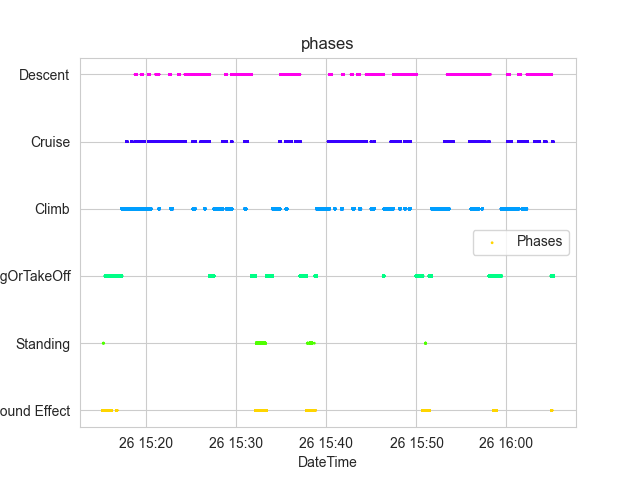

In [272]:
plot_all_phases(filtered_df)

In [284]:
def sliding_window_grouping_using_mode(df):
    ## slow
    time_interval = '5S'  # 5 seconds interval, can be changed to other valid string formats
    window_size = df.set_index('DateTime').resample(time_interval).size()
    dominant_phase = df.groupby(pd.Grouper(key='DateTime', freq=time_interval))['Phase'].apply(lambda x: x.mode().iloc[0])
    result = pd.DataFrame({'Phase': dominant_phase, 'Count': window_size}).reset_index()

    # Merge consecutive windows with the same phase
    merged_windows = []
    current_phase = None
    start_time = None
    for index, row in result.iterrows():
        if row['Phase'] != current_phase:
            # New phase, start a new window
            if current_phase is not None:
                merged_windows.append({'Phase': current_phase, 'StartDateTime': start_time, 'EndDateTime': prev_time})
            current_phase = row['Phase']
            start_time = row['DateTime']
        prev_time = row['DateTime']

    # Add the last window
    if current_phase is not None:
        merged_windows.append({'Phase': current_phase, 'StartDateTime': start_time, 'EndDateTime': prev_time})

    merged_df = pd.DataFrame(merged_windows)
    return merged_df

In [291]:
grouped_phases= sliding_window_grouping_using_mode(filtered_df)
grouped_phases

,Phase,StartDateTime,EndDateTime
0,Hover In Ground Effect,2023-01-26 15:15:05,2023-01-26 15:15:20
1,LandingOrTakeOff,2023-01-26 15:15:25,2023-01-26 15:15:50
2,Hover In Ground Effect,2023-01-26 15:15:55,2023-01-26 15:16:00
3,LandingOrTakeOff,2023-01-26 15:16:05,2023-01-26 15:17:10
4,Climb,2023-01-26 15:17:15,2023-01-26 15:18:40
...,...,...,...
127,Cruise,2023-01-26 16:03:35,2023-01-26 16:03:35
128,Descent,2023-01-26 16:03:40,2023-01-26 16:04:10
129,Cruise,2023-01-26 16:04:15,2023-01-26 16:04:15
130,Descent,2023-01-26 16:04:20,2023-01-26 16:04:55


In [292]:
def sliding_window_phases_labeling_using_mode(df):
    time_interval = '5S'  # 5 seconds interval, can be changed to other valid string formats
    dominant_phase = df.groupby(pd.Grouper(key='DateTime', freq=time_interval))['Phase'].apply(lambda x: x.mode().iloc[0])
    return dominant_phase

In [293]:
import mplcursors
import matplotlib.pyplot as plt


def plot_phases_altitude(data):
    unique_phase_values = data['Phase'].unique()

    # Generate a list of random colors for unique values using seaborn
    colors = sns.color_palette("deep", len(unique_phase_values))

    # Create a dictionary mapping unique values to random colors
    color_dict = dict(zip(unique_phase_values, colors))
    # Create the plot
    plt.figure(figsize=(10, 6))


    # Plot each phase separately with its corresponding color
    for phase, color in color_dict.items():
        phase_data = data[data['Phase'] == phase]
        plt.scatter(phase_data['DateTime'], phase_data['Altitude(AGL)'], label=f'Phase: {phase}', color=color, marker='o')

    # Customize the plot
    plt.xlabel('Time')
    plt.ylabel('Altitude')
    plt.title('Time Series with Labeled Phases')
    plt.legend()
    plt.grid(True)
    mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(f"Phase: {data['Phase'][sel.target.index]}"))

    # Show the plot
    plt.show()

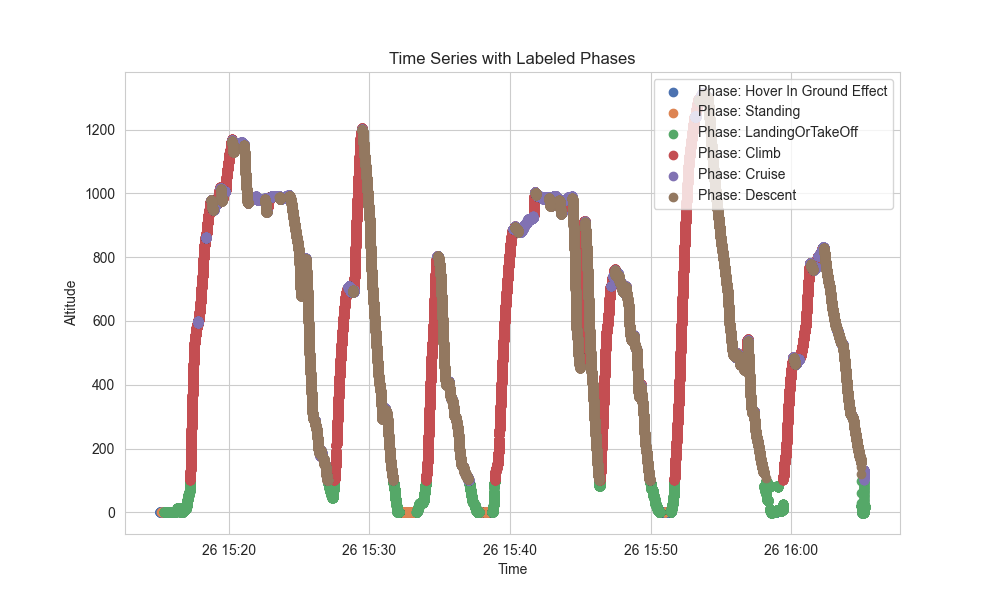

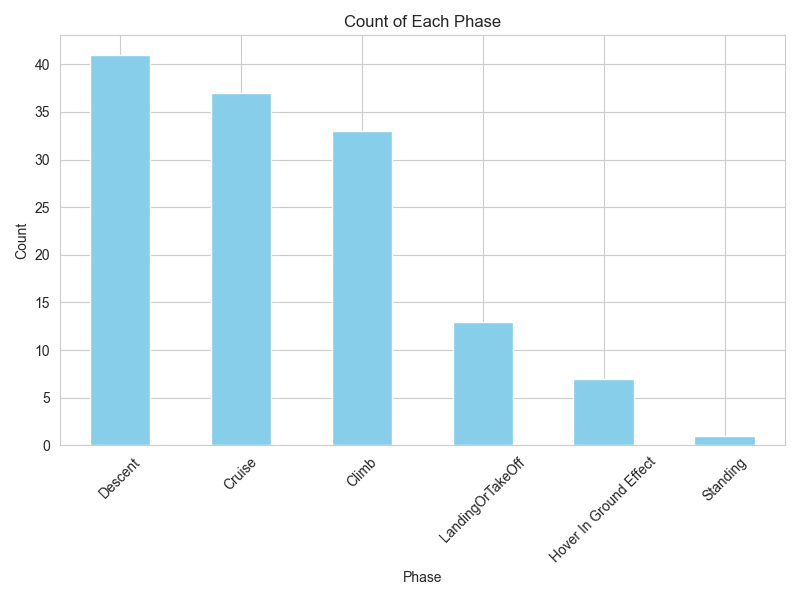

In [297]:
plot_phases_altitude(filtered_df)
phase_counts = sliding_window_grouping_using_mode(filtered_df)['Phase'].value_counts()
# Create a bar chart
plt.figure(figsize=(8, 6))
phase_counts.plot(kind='bar', color='skyblue')
# Set labels and title
plt.xlabel('Phase')
plt.ylabel('Count')
plt.title('Count of Each Phase')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



28


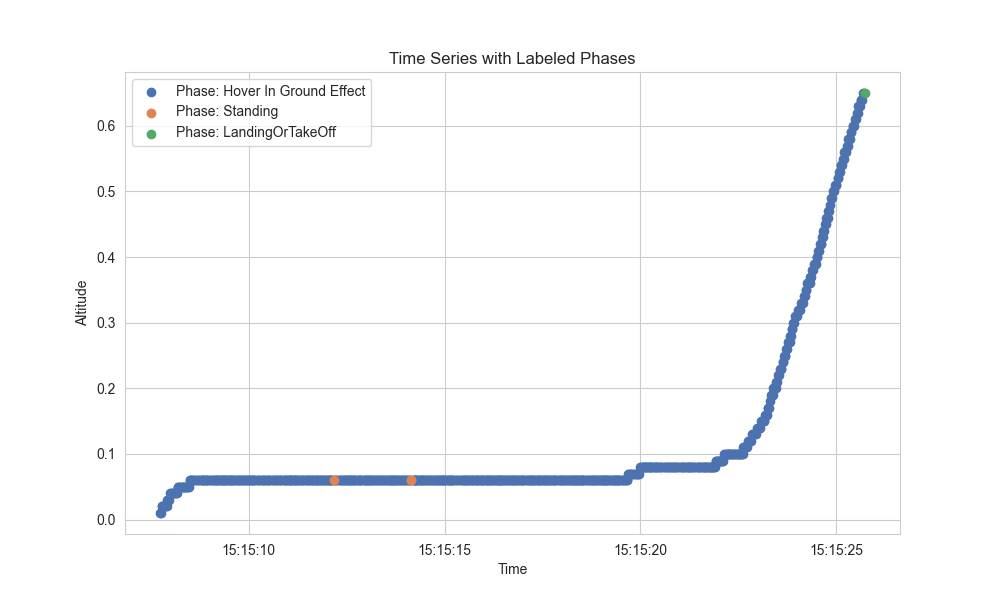

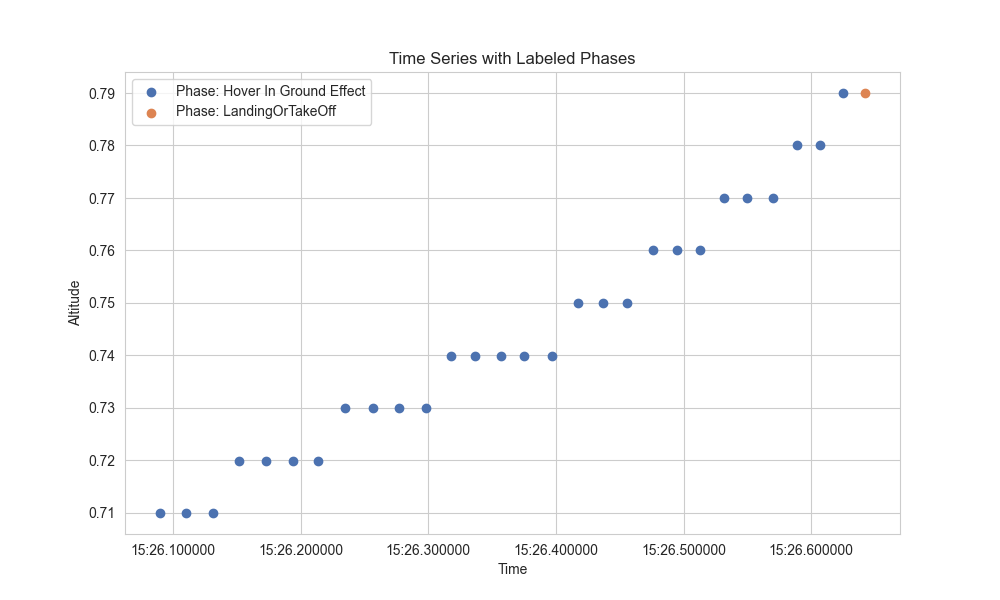

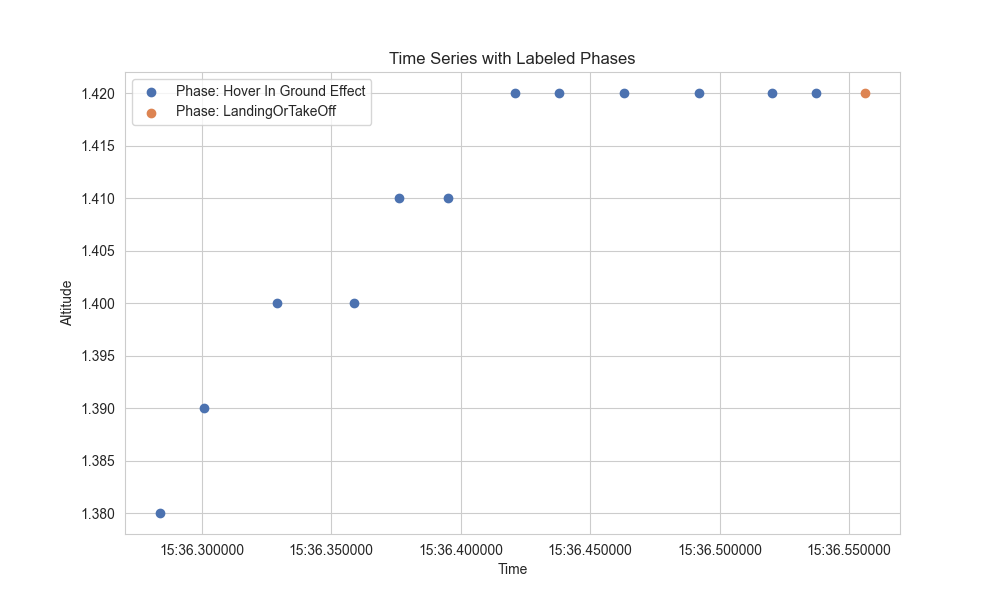

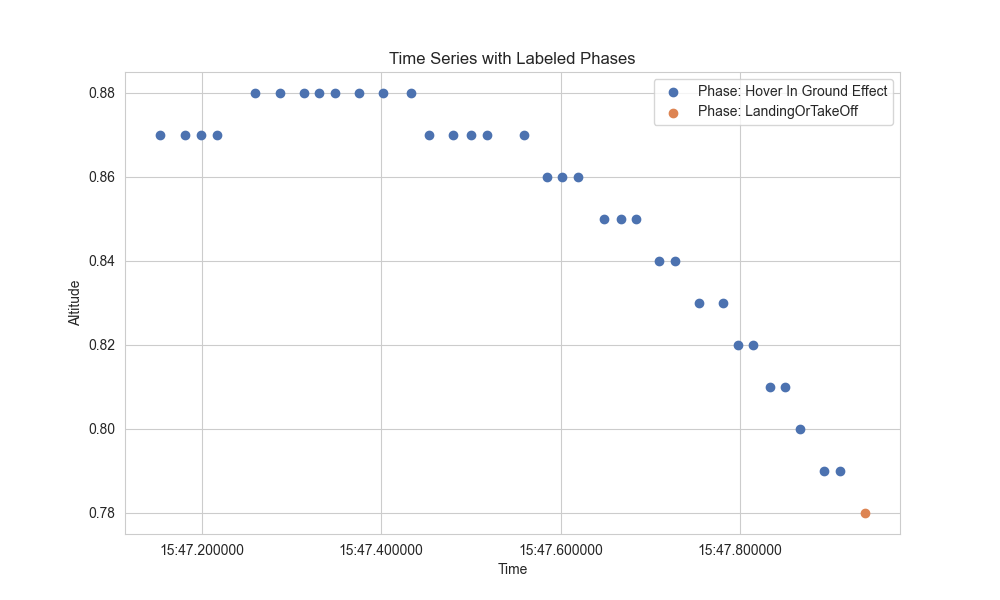

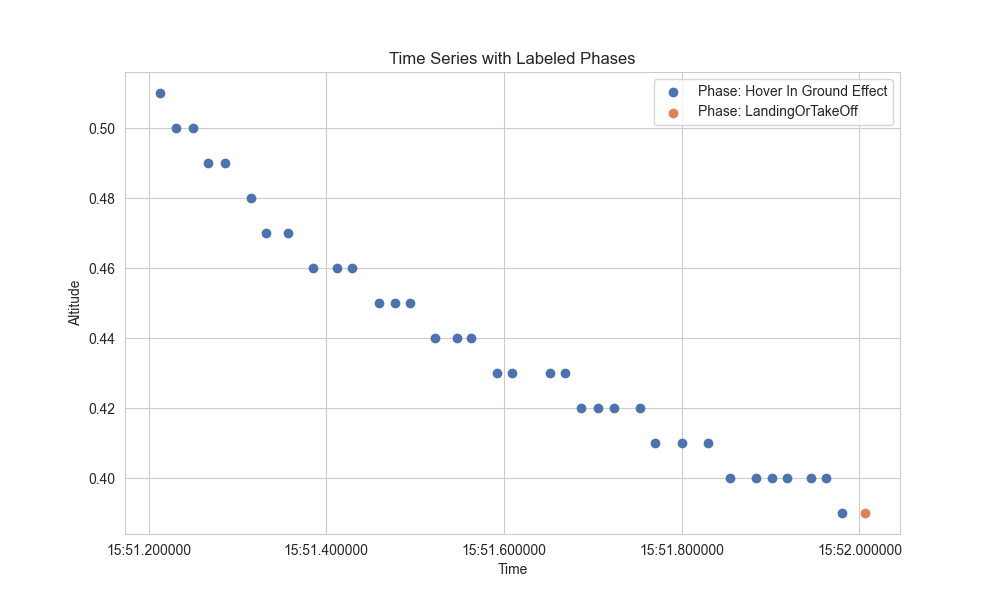

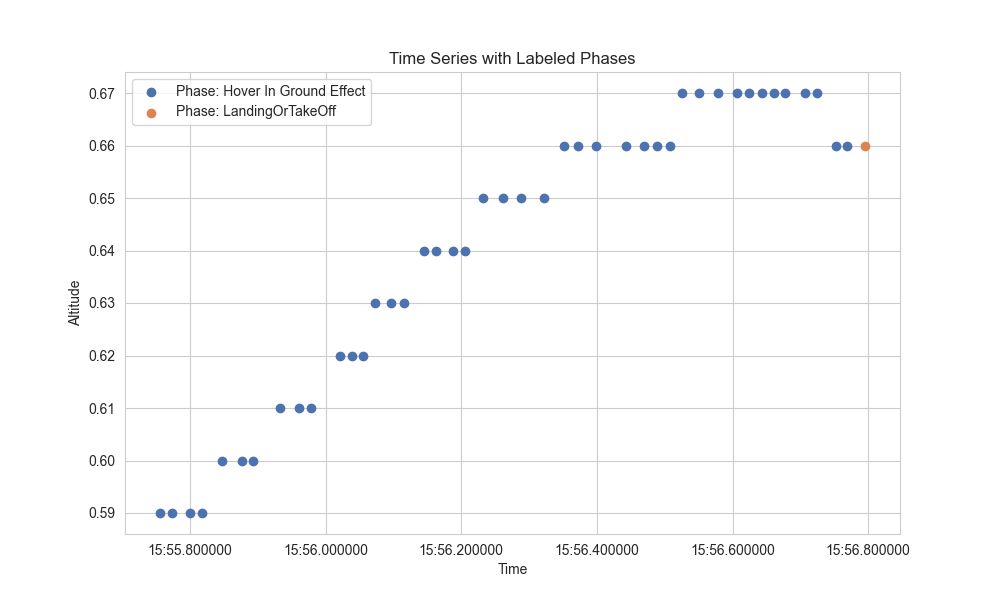

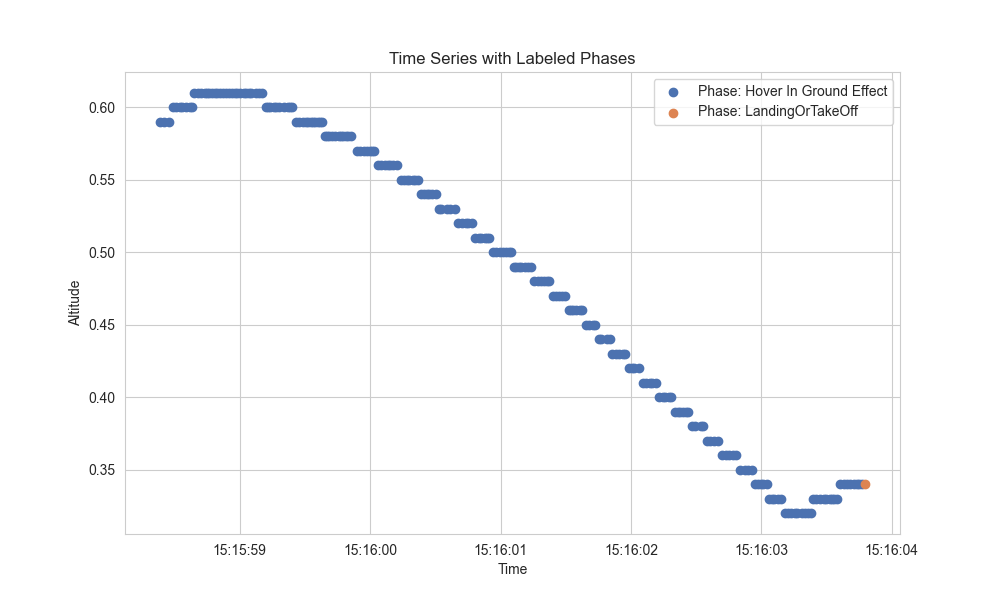

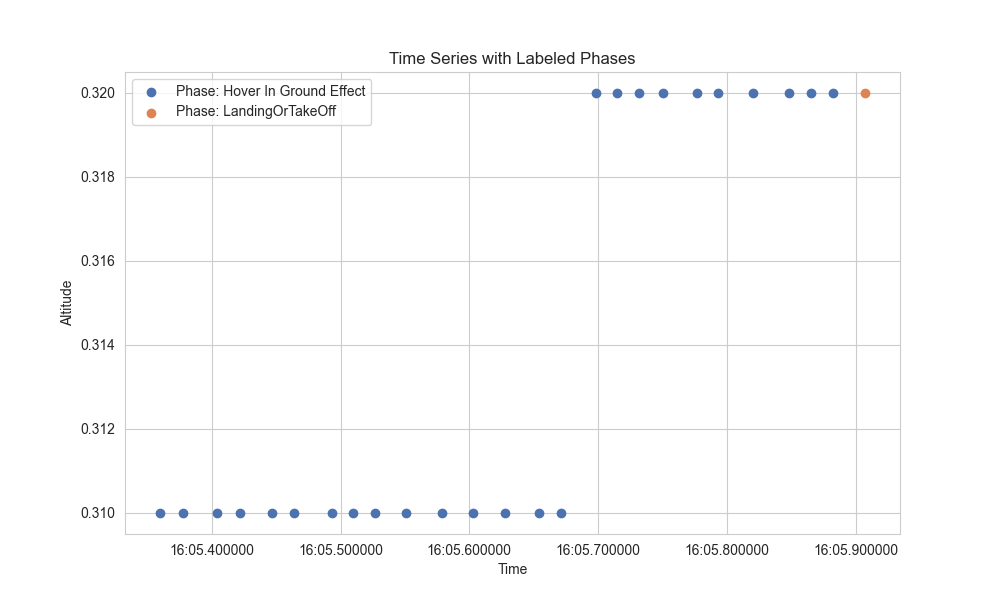

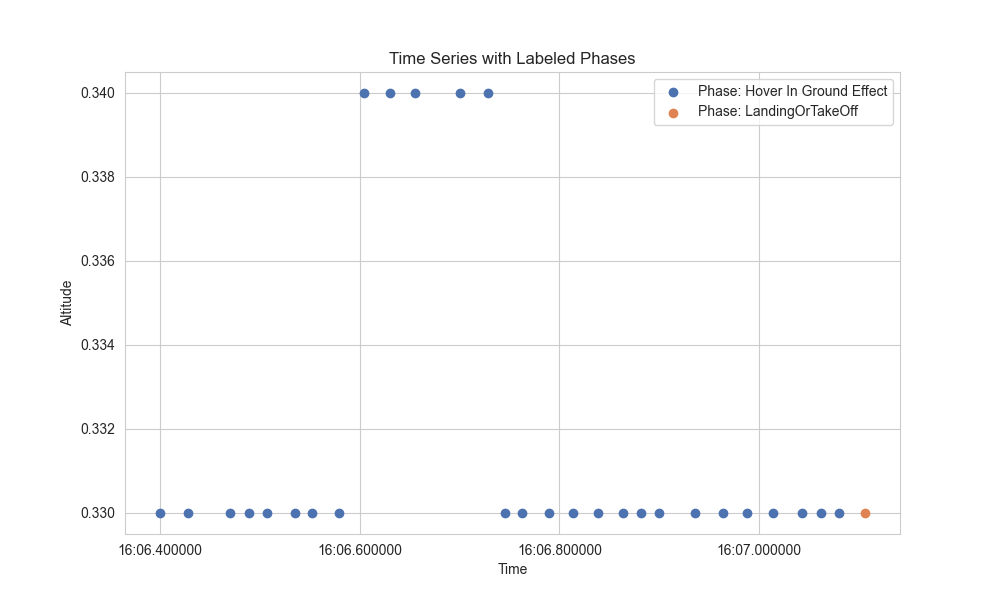

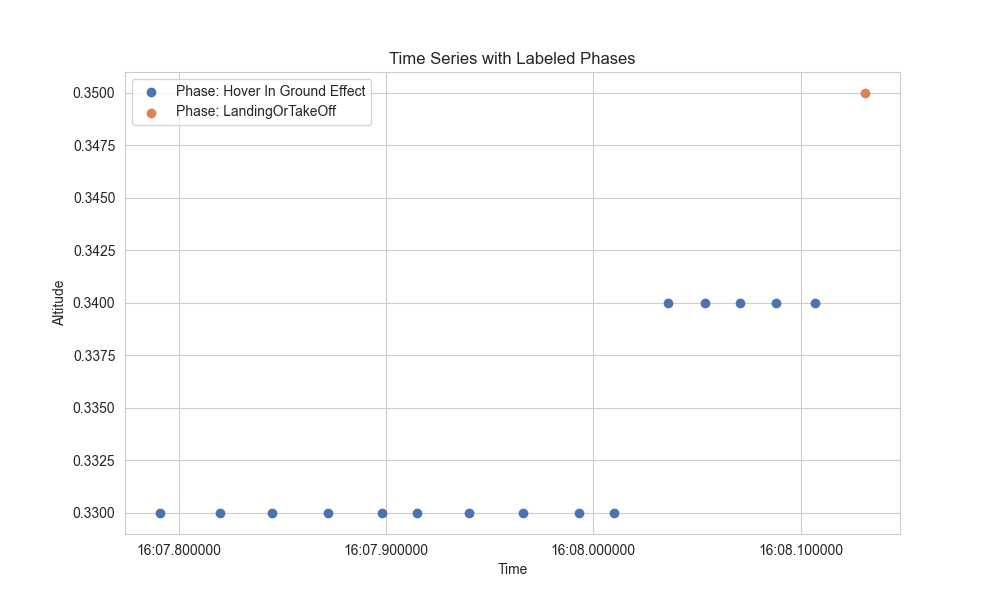

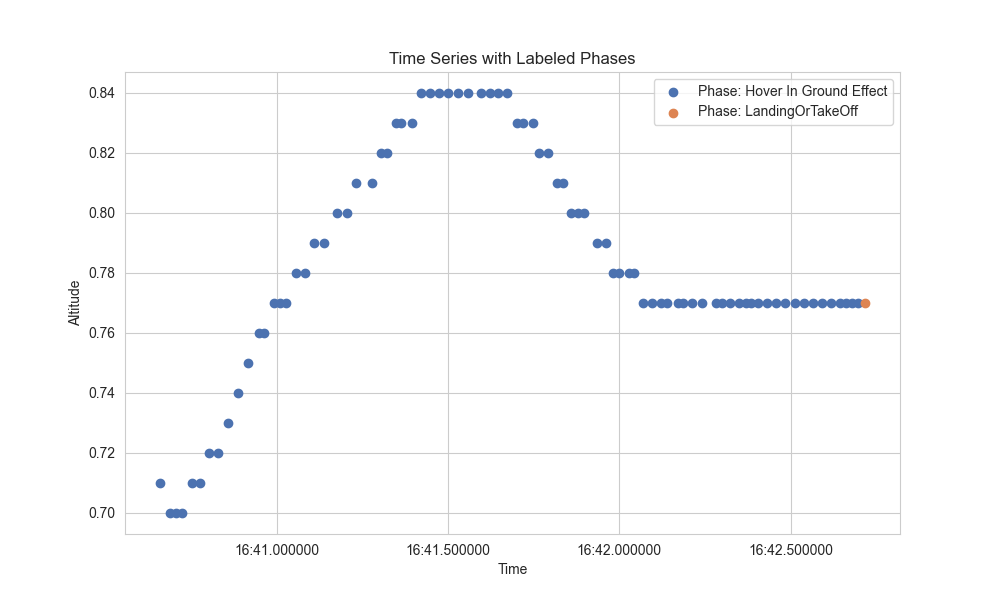

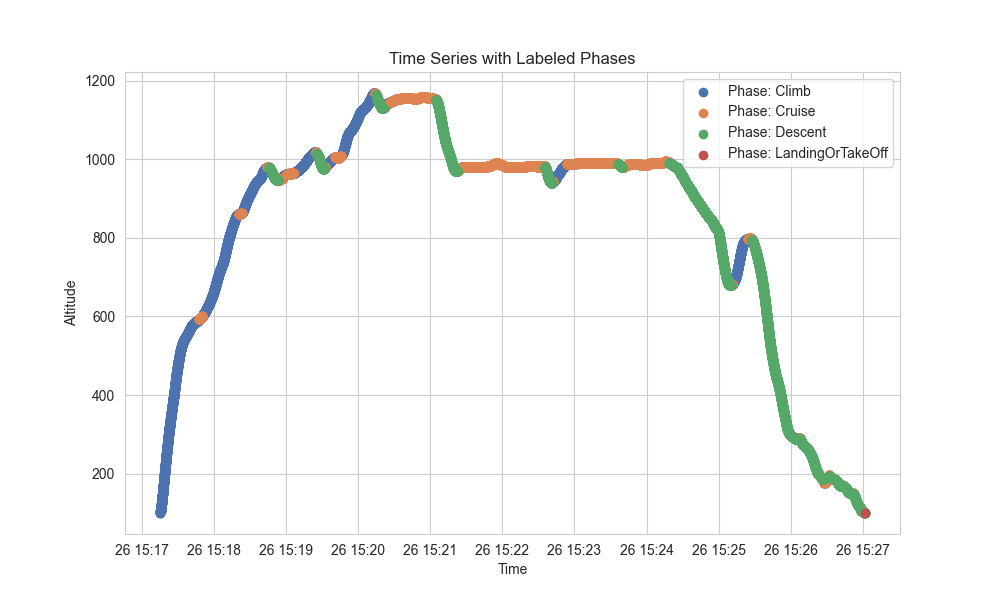

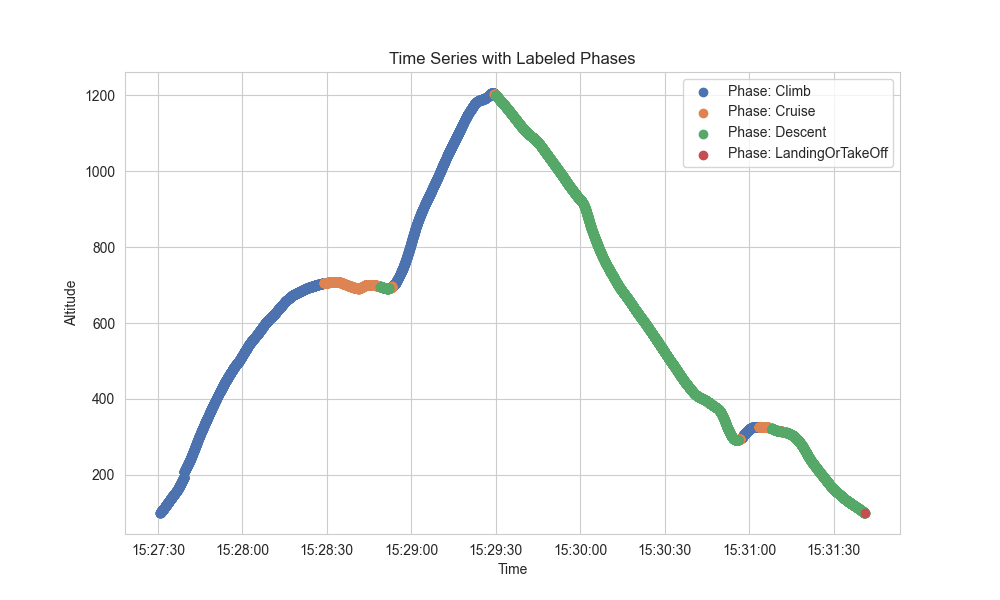

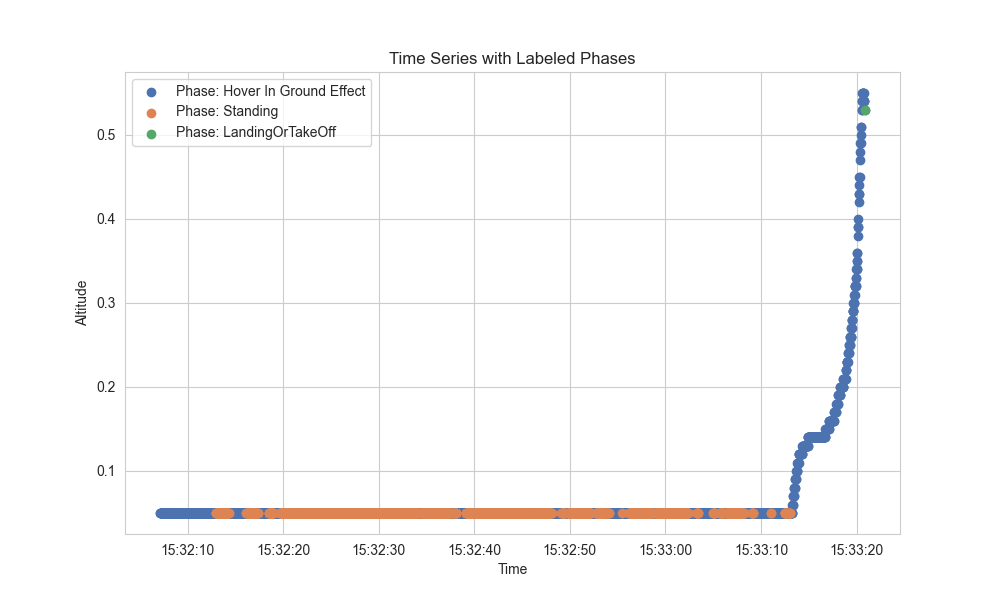

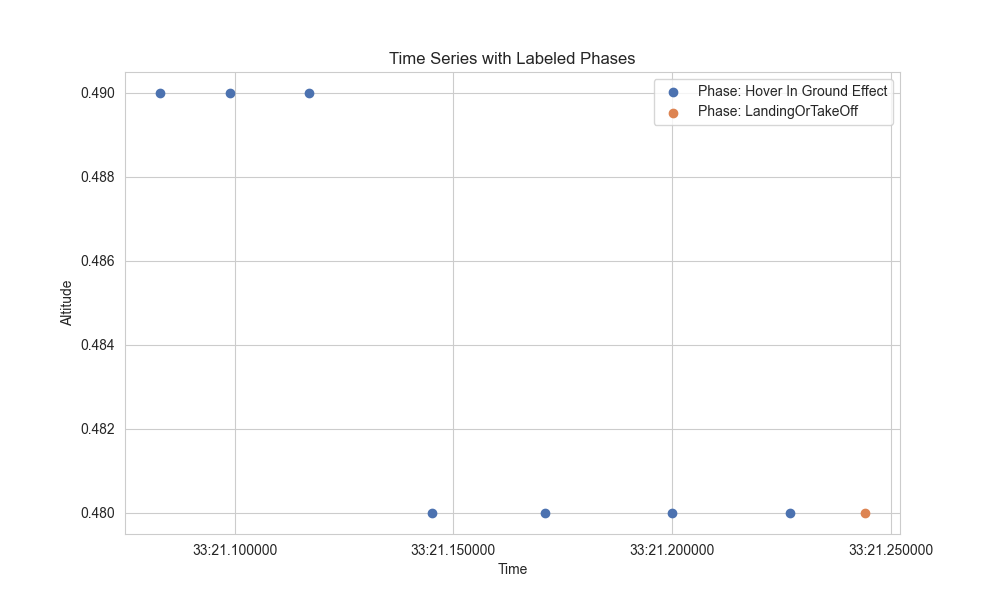

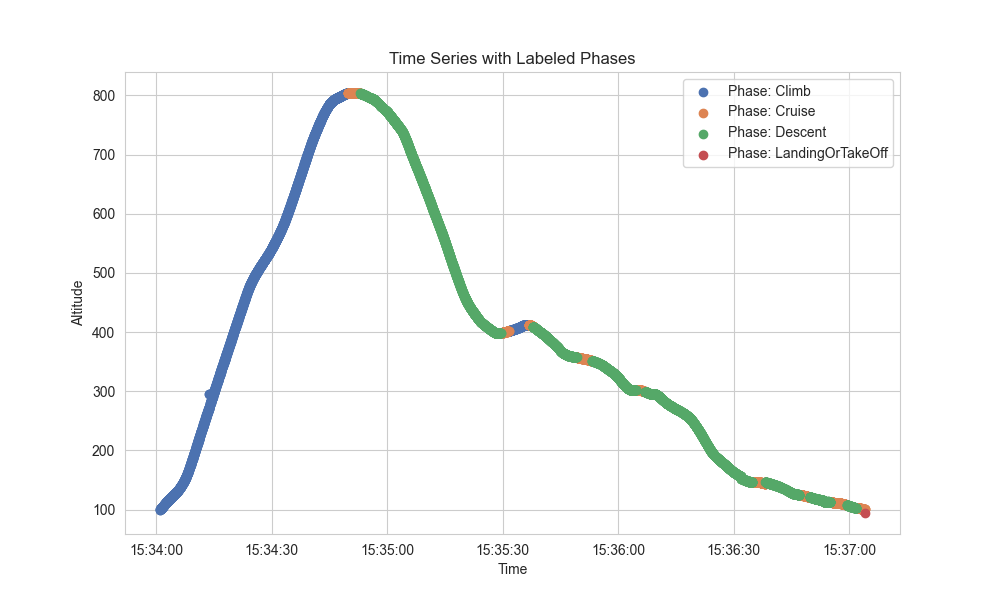

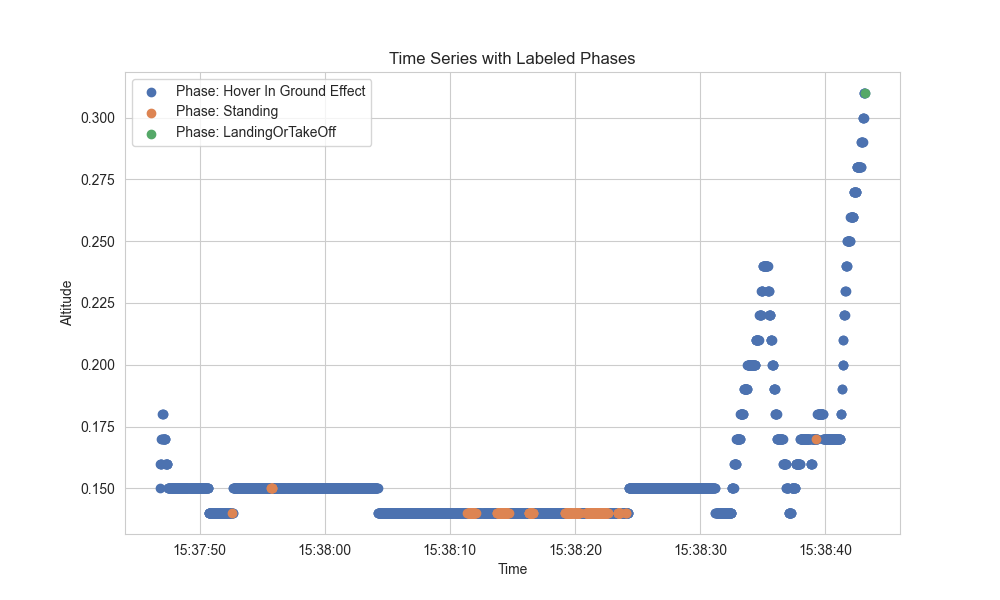

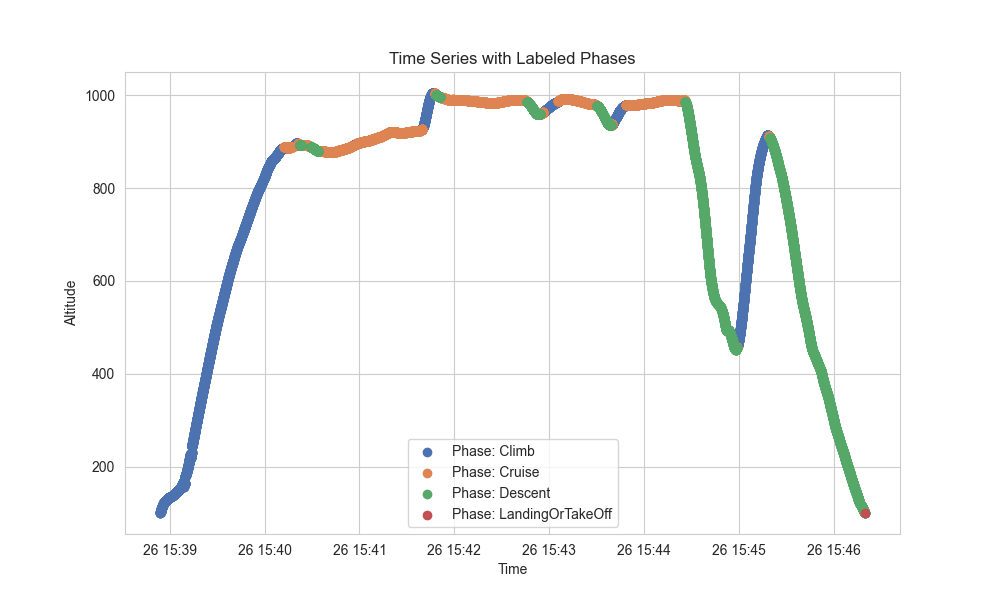

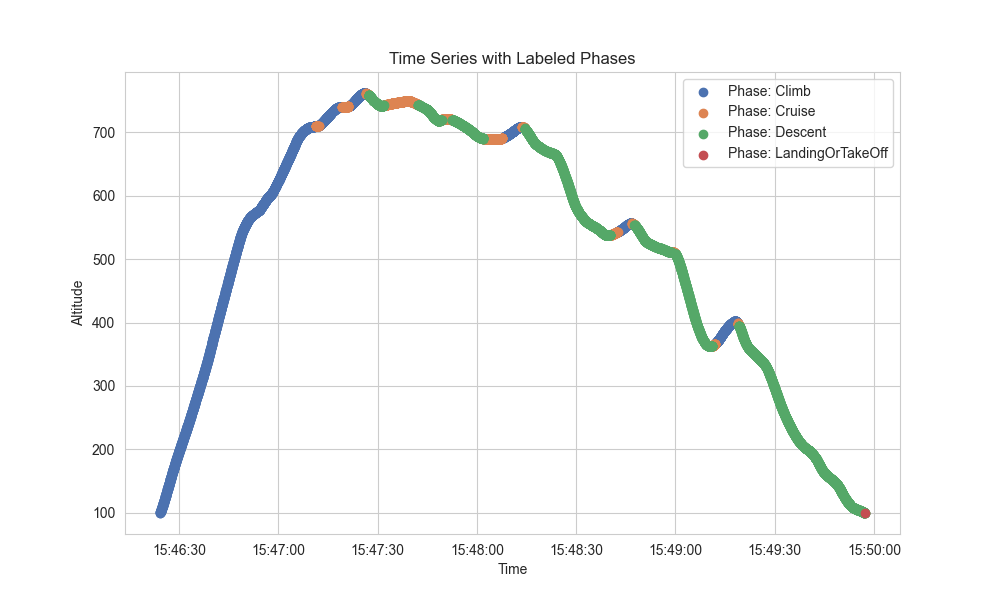

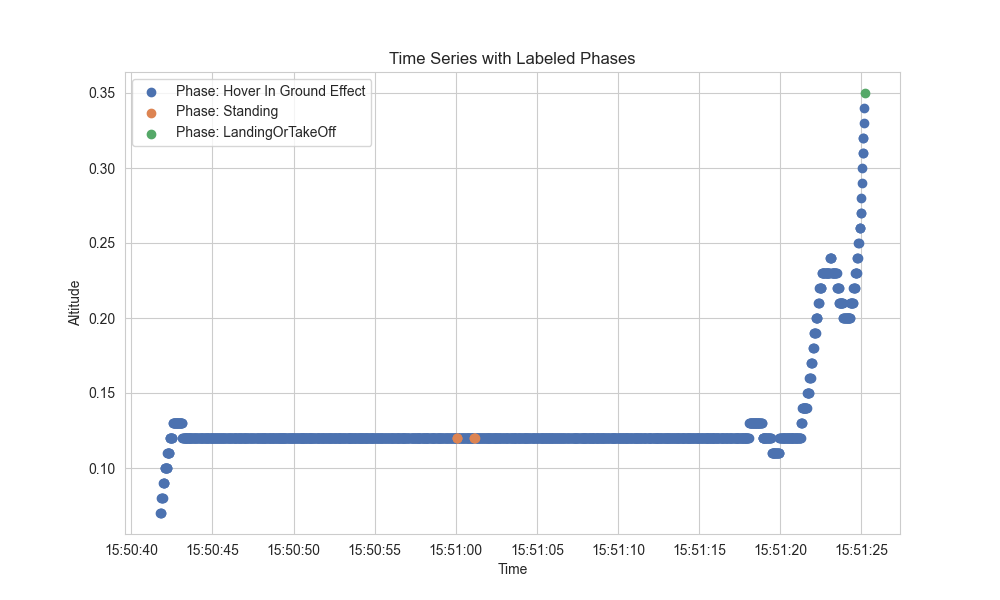

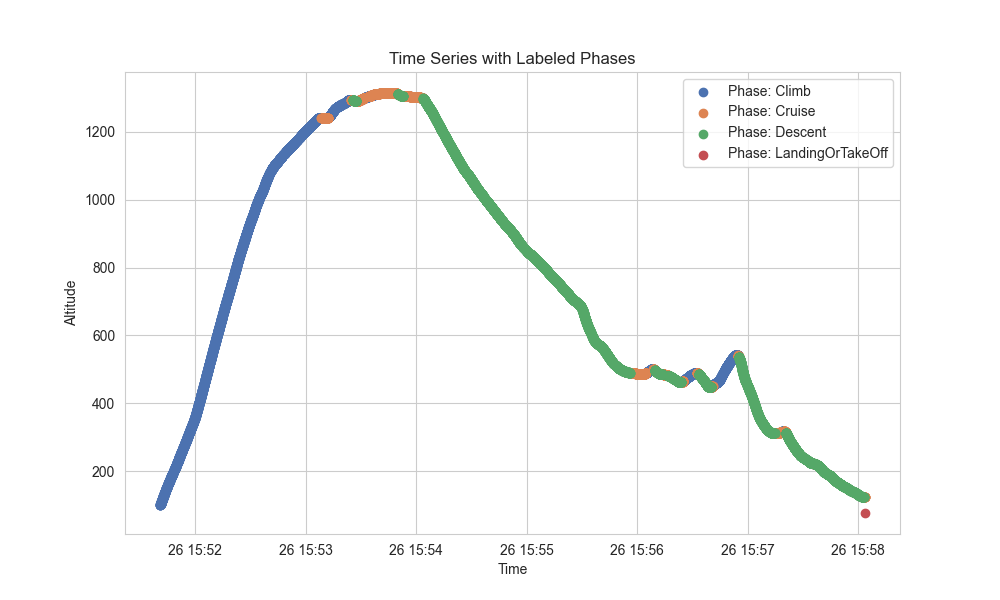

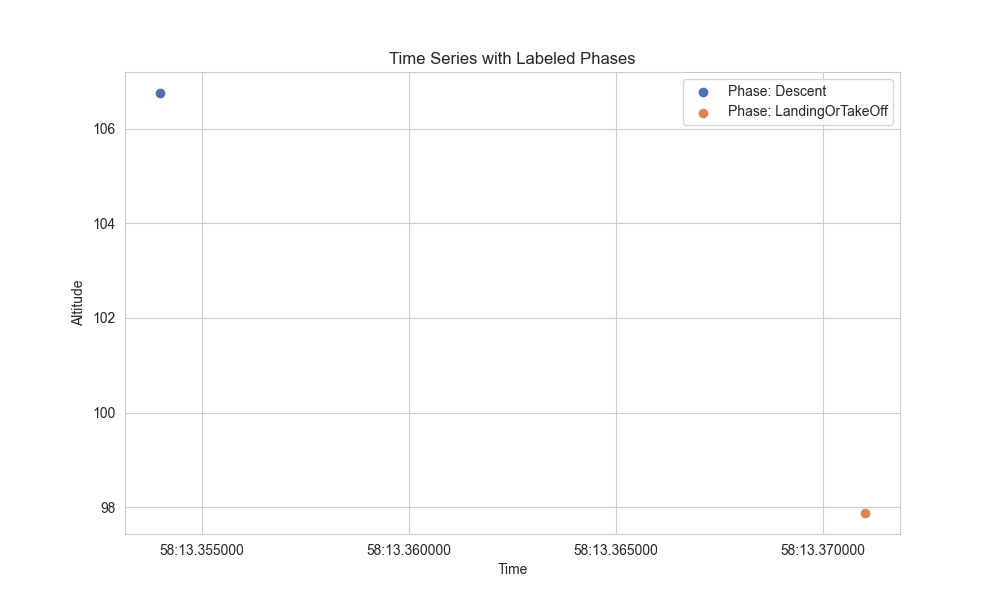

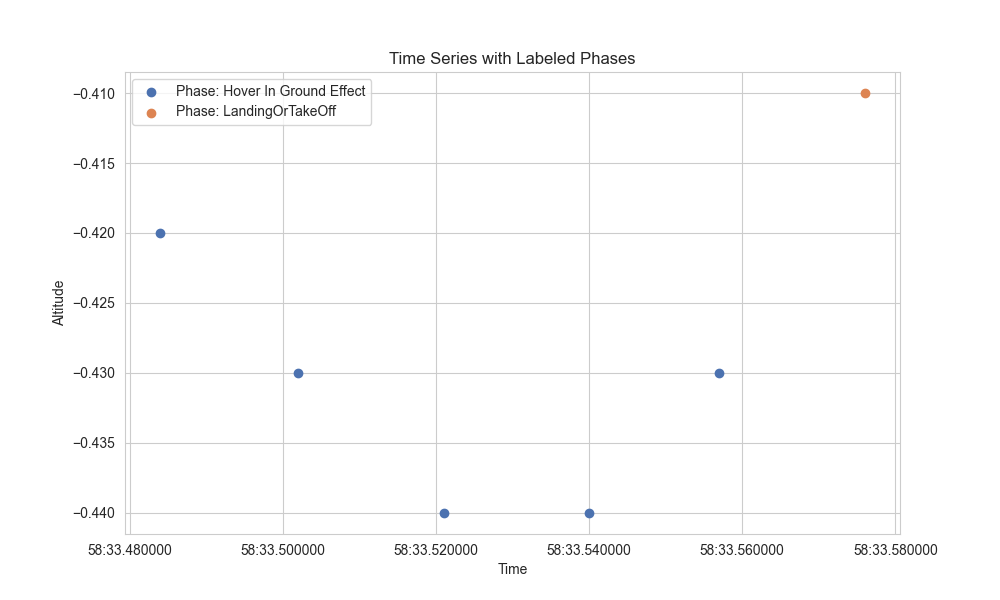

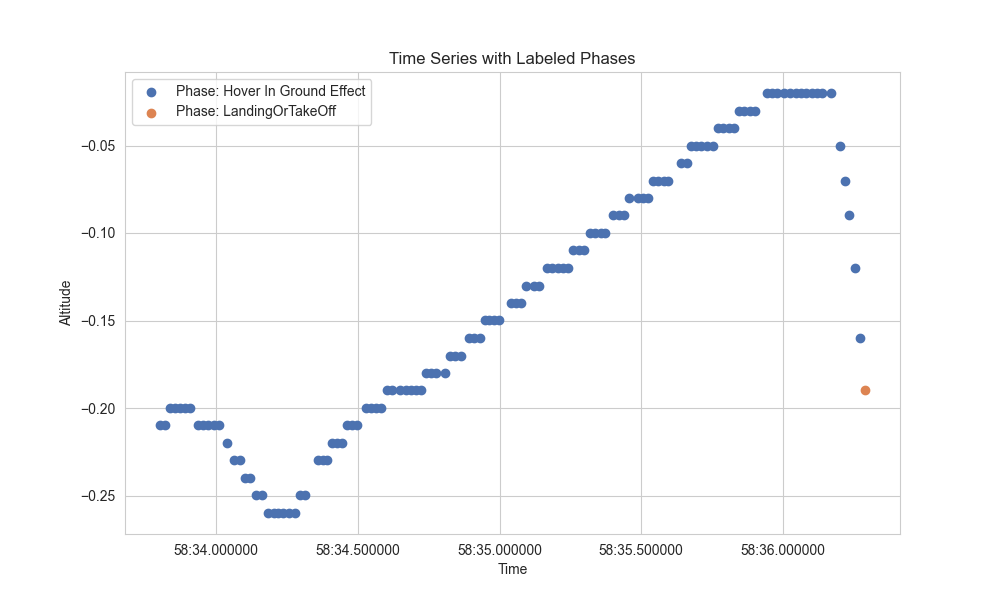

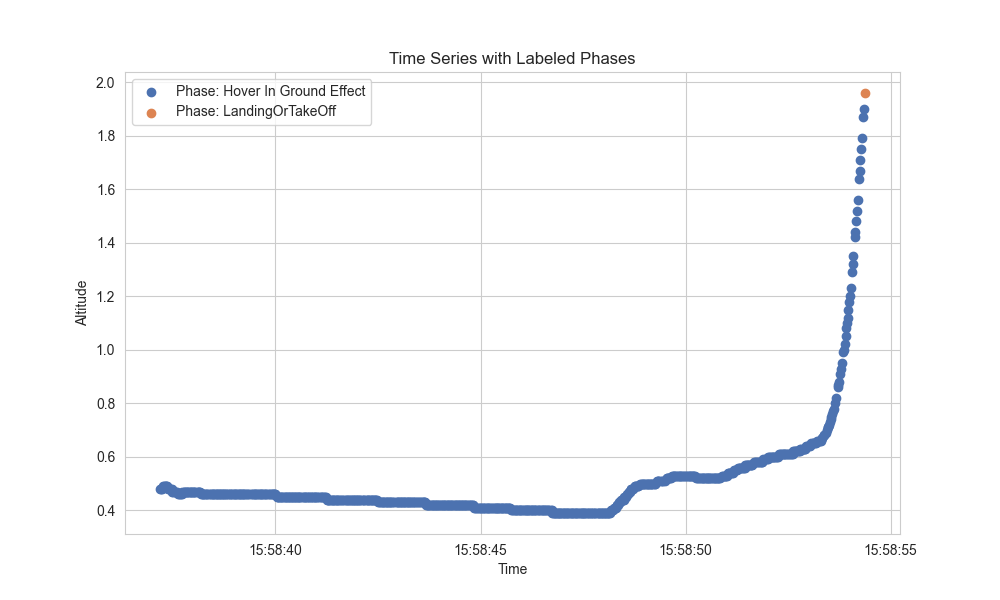

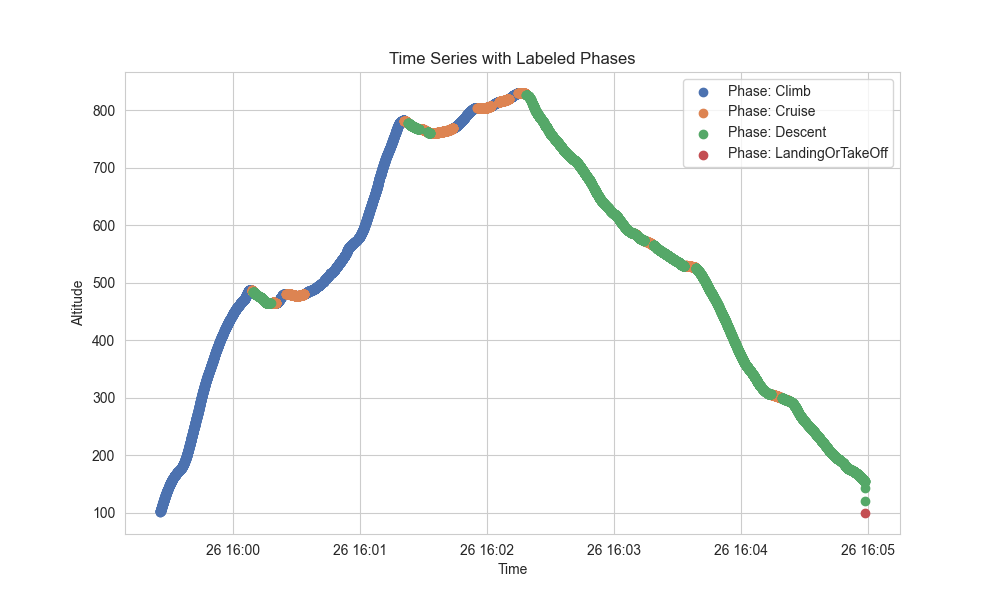

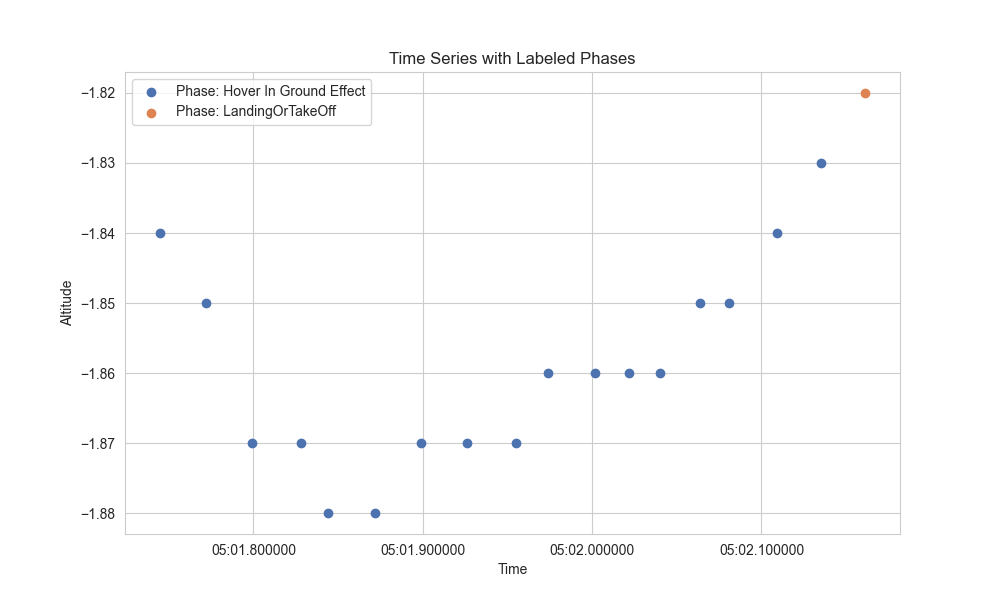

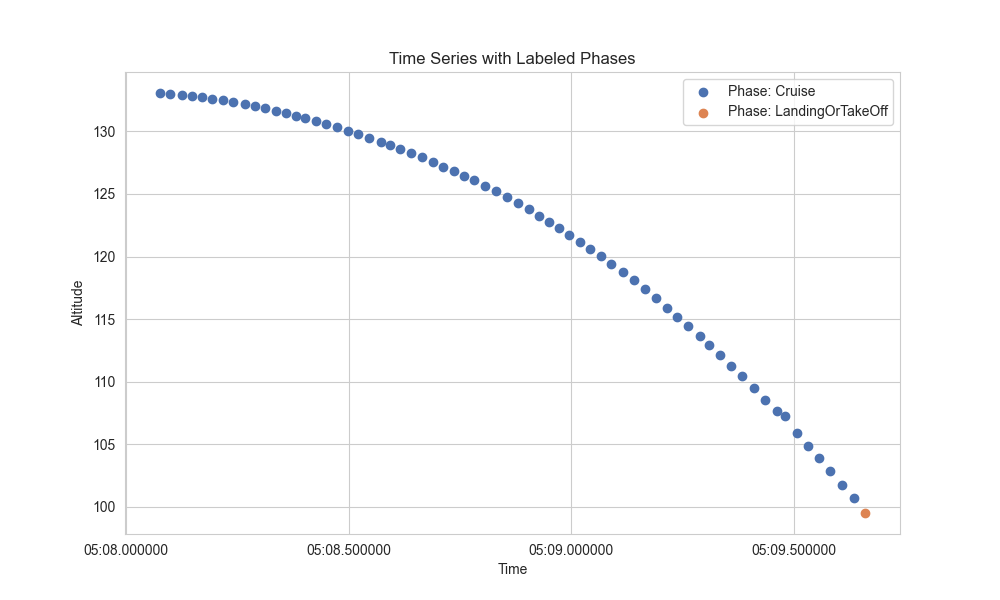

In [249]:
flights = []
last_index = 0
for i in range(len(filtered_df)):
    if filtered_df['Phase'][i] == 'LandingOrTakeOff' and \
            (filtered_df['Phase'][i-1] != 'LandingOrTakeOff' or last_index==0):
        flight = filtered_df.loc[last_index:i]
        flights.append(flight)
        while i< len(filtered_df) and filtered_df['Phase'][i] == 'LandingOrTakeOff':
            i+=1
        last_index=i
print(len(flights))
for flight in flights:
    plot_phases_altitude(flight)